# Loading Data and Preliminaries

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import torch
from copy import deepcopy
from torch.utils.data import Dataset, DataLoader,TensorDataset
from torch import nn

The dataset consists of simulations of the trajectory of a single particle. The simulations are of varying length. All simulations start at t = 0 and end at t = 10 ± 1. A subset of the simulations are continued for an additional 4 ± 2 seconds, i.e. ending the entire simulation at t = 14 ± 3.

There are 150 simulations for training, 100 for validation, and 100 for testing. The simulations are of 100 ± 10 steps alongside their continuation of 40 ± 20 steps.

### ML Task:

Using the positions of the particle during a simulation up to t = 10±1, continue its trajectory for an additional 4 ± 2 seconds.

In [2]:
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train =  pd.read_pickle('data/train/simulation.pickle')
simulation_valid = pd.read_pickle('data/valid/simulation.pickle')
simulation_test = pd.read_pickle('data/test/simulation.pickle')
"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = pd.read_pickle('data/train/simulation_continued.pickle')
simulation_continued_valid = pd.read_pickle('data/valid/simulation_continued.pickle')
simulation_continued_test = pd.read_pickle('data/test/simulation_continued.pickle')

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [3]:
print('Overview of no. datapoints:\n')
print('Since len(simulation_continued_train) < len(simulation_train), thus can only use a subset of initial simulations')
print('simulation_train is cut down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

Overview of no. datapoints:

Since len(simulation_continued_train) < len(simulation_train), thus can only use a subset of initial simulations
simulation_train is cut down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations


In [4]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [5]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

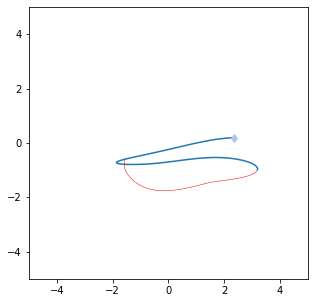

In [6]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])

## Problem Formulation:

The task is to predict the continuation of particle $p_1$'s trajectory. Given the particle's positions during a simulation up to $10 \pm 1$ seconds, the particle's positions for an additional $4 \pm 2$ seconds need to be predicted. Thus, there is a need to model $f_t(position_0,..., position_{100 \pm 10}) \in ( \mathbb{R}, \mathbb{R})$ for $t \in [(100 \pm 10 + 20), (100 \pm 10 + 60)]$, where $t$ is a time step in the extended simulation, and $position_0,...,position_{100 \pm 10}$ are the positions of particle $p_1$ for the first $100 \pm 10$ steps, and $f_t$ is the position of particle $p_1$ at at time step $t$.

Based on this description, the machine learning task is to map variable length sequences to other sequences of different length, which are not aligned with the original sequence. This is a regression problem, where the $x$ and $y$-coordinates of each position needs to be predicted. Thus, suitable measures of performance are mean square error (MSE), which would measures the average squared difference between the estimated positions and the actual positions, as well as cosine similarity, which would measures the similarity between the estimated and actual positions. Therefore, a low MSE and a high cosine similarity are wanted. In these cases, it could be argued that the prediction is very close to the true positions.

## Data Handling and Preprocessing

In [7]:
class PositionsDataset(Dataset):
    def __init__(self, positions, continued_positions):
        self.positions = positions
        self.continued_positions = continued_positions
        
    def __getitem__(self, index):
        """
         Given an index of a simulation, an object of this class can return a FloatT ensor of the positions of the simulation.
        """
        position = torch.FloatTensor(self.positions[index])
        continued_position = torch.FloatTensor(self.continued_positions[index])
        return position, continued_position
        
    def __len__(self):
        return len(self.continued_positions)

In [8]:
train_dataset = PositionsDataset(simulation_train_task32, simulation_continued_train)
valid_dataset = PositionsDataset(simulation_valid, simulation_continued_valid)
test_dataset = PositionsDataset(simulation_test, simulation_continued_test)

## Model Formulation and Implementation

A sequence to sequence model fits the task and the sequential data. Sequence to sequence models are implemented using an encoder RNN cell, which produces an encoding (representation) of the input sequence, and a decoder RNN cell, which produces the output. The encoder's hidden state at the end of the input sequence is passed to the decoder to initialize it's hidden state. The decoder performs a single step of decoding by producing the prediction for the current time step. The output sequence will not be assumed to consist of independent positions. Therefore, the previously predicted position will be passed to the decoder at each decoding step, in addition to the hidden state. Thus, it could be assumed that the error could increase as when the model predicts later timesteps. 

Based on these choices, the encoder in the model can formulated as $encoder(position_0,..., position_k)=h_k$, where $position_0,...,position_k$ is the input sequence of positions, and $h_k$ is the hidden state of the encoder at the last time step. The decoder can be formulated as $decoder(h_k)=position_{k+1}, h_{k+1}$ in the base case, where $position_{k+1}$ is the prediction, and $h_{k+1}$ is the new hidden state. In the general case the decoder can be formulated as $decoder(h_{i-1}, position_{i-1})= h_{i}, position_{i}$, where $h_{i-1}, position_{i-1}$ and $h_{i}, position_{i}$ are respectively the previous and new time step's hidden state and prediction. Thus, the model can predict future positions.

To implement the Encoder and Decoder a GRU layer will be used. The GRU ('Gated Recurrent Unit') is a simplification of LSTM as it has only a 'reset gate' and an 'update gate'. The 'update gate' determines the information in the hidden state that should be updated, and the reset gate determines the information in the old hidden state that should be ignored when computing the update. A GRU RNN is used instead of an LSTM because  GRU is faster to train and uses less memory when training on small data sets.

In [9]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim, n_layers, dropout):
        super().__init__()
        
        self.rnn = nn.GRU(input_dim, hid_dim, num_layers = n_layers, dropout = dropout, batch_first=True)       
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
    def forward(self, x):
        out, hidden = self.rnn(x)
        out = self.fc_out(out)
        
        return out, hidden

In [10]:
class Decoder(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim, n_layers, dropout):
        super().__init__()

        self.rnn = nn.GRU(input_dim, hid_dim, num_layers = n_layers, dropout = dropout, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, output_dim)    
        
    def forward(self, input_data, hidden):
        
        input_data = input_data.unsqueeze(0)
        output, hidden = self.rnn(input_data, hidden)
        prediction = self.fc_out(output.squeeze(0))
        
        return prediction, hidden

In [11]:
import torch.optim as optim
import random

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        self.optimizer = optim.Adam(self.parameters(), lr=1e-3)
        self.criterion = nn.MSELoss()
        
    def forward(self, initial_data, continued_data):

        batch_size = continued_data.shape[0]
        continued_data_len = continued_data.shape[1]
        position_dim = continued_data.shape[2]
        
        #tensor to store decoder outputs
        outputs = torch.zeros(batch_size, continued_data_len, position_dim).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        output, hidden = self.encoder(initial_data)
        
        #first input to the decoder
        input_data = output[:, -1, :]
        outputs[:, 0, :] = input_data
        
        for t in range(1, continued_data_len):
            #pass the output of the encoder for the last time step and the hidden state
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden = self.decoder(input_data, hidden)
            
            #place predictions in a tensor holding predictions for each token
            outputs[:,t,:] = output
            
            input_data = output
            
        return outputs

## Model Training

At the start of training, a DataLoader object is initialized, which takes the training data and a batch size of 1. By using a batch size of 1 simulation, the sequences of multiple simulations do not need to be padded to ensure they are of the same size. For training the model, MSE is used to compute the loss.

In [12]:
BATCH_SIZE = 1
N_EPOCHS = 30
N_LAYERS = 2
INPUT_DIM = 2
HIDDEN_DIM = 32 #dimension of the lstm's hidden state
OUTPUT_DIM = 2
DROPOUT = 0.5

# check if gpu is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# initiate seq2seq model
enc = Encoder(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
dec = Decoder(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)

seq2seq = Seq2Seq(enc, dec, device).to(device)

In [14]:
import time
from tqdm import tqdm

def train(train_dataset):
    epoch_loss = 0
    seq2seq.train()
    dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

    for i, (sim_train, sim_cont_train) in enumerate(tqdm(dataloader)):
        seq2seq.optimizer.zero_grad()
        output = seq2seq(sim_train.to(device), sim_cont_train.to(device))
        loss = seq2seq.criterion(output, sim_cont_train.to(device))
        loss.backward()
        seq2seq.optimizer.step()
        epoch_loss += loss.item()
        torch.cuda.empty_cache()

    return epoch_loss / len(dataloader)


def evaluate(valid_dataset):
    epoch_loss = 0
    seq2seq.eval()
    dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

    with torch.no_grad():
        for i, (sim_valid, sim_cont_valid) in enumerate(dataloader):
            output = seq2seq(sim_valid.to(device), sim_cont_valid.to(device))
            loss = seq2seq.criterion(output, sim_cont_valid.to(device))
            epoch_loss += loss.item()
            torch.cuda.empty_cache()
    
    return epoch_loss / len(dataloader)


best_valid_loss = float('inf')
train_loss_arr = []
val_loss_arr = []

for epoch in range(N_EPOCHS):
    epoch_start_time = time.time()
    train_loss = train(train_dataset)
    val_loss = evaluate(valid_dataset)
    train_loss_arr.append(train_loss)
    val_loss_arr.append(val_loss)
    
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(seq2seq.state_dict(), 'seq2seq_model.pt')
    
    print('-' * 76)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'train loss {:8.3f} '
          'valid loss {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time, 
                                           train_loss_arr[-1],
                                           val_loss_arr[-1]))
    print('-' * 76)

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:07<00:00, 19.52it/s]


----------------------------------------------------------------------------
| end of epoch   0 | time:  8.65s | train loss    2.741 valid loss    2.638 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 23.05it/s]


----------------------------------------------------------------------------
| end of epoch   1 | time:  7.47s | train loss    2.198 valid loss    2.455 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 23.13it/s]


----------------------------------------------------------------------------
| end of epoch   2 | time:  7.46s | train loss    2.055 valid loss    2.183 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 23.07it/s]


----------------------------------------------------------------------------
| end of epoch   3 | time:  7.49s | train loss    1.934 valid loss    2.066 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 22.48it/s]


----------------------------------------------------------------------------
| end of epoch   4 | time:  7.66s | train loss    1.846 valid loss    1.958 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 23.00it/s]


----------------------------------------------------------------------------
| end of epoch   5 | time:  7.47s | train loss    1.752 valid loss    1.964 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 23.19it/s]


----------------------------------------------------------------------------
| end of epoch   6 | time:  7.45s | train loss    1.642 valid loss    2.032 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 22.96it/s]


----------------------------------------------------------------------------
| end of epoch   7 | time:  7.49s | train loss    1.512 valid loss    1.955 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 23.02it/s]


----------------------------------------------------------------------------
| end of epoch   8 | time:  7.49s | train loss    1.428 valid loss    1.917 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 22.99it/s]


----------------------------------------------------------------------------
| end of epoch   9 | time:  7.49s | train loss    1.291 valid loss    1.671 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 22.96it/s]


----------------------------------------------------------------------------
| end of epoch  10 | time:  7.51s | train loss    1.202 valid loss    1.655 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 23.01it/s]


----------------------------------------------------------------------------
| end of epoch  11 | time:  7.51s | train loss    1.116 valid loss    1.497 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 22.97it/s]


----------------------------------------------------------------------------
| end of epoch  12 | time:  7.50s | train loss    1.030 valid loss    1.534 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 23.17it/s]


----------------------------------------------------------------------------
| end of epoch  13 | time:  7.45s | train loss    0.965 valid loss    1.294 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 22.90it/s]


----------------------------------------------------------------------------
| end of epoch  14 | time:  7.56s | train loss    0.870 valid loss    1.158 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 23.16it/s]


----------------------------------------------------------------------------
| end of epoch  15 | time:  7.48s | train loss    0.847 valid loss    1.108 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 23.11it/s]


----------------------------------------------------------------------------
| end of epoch  16 | time:  7.48s | train loss    0.747 valid loss    1.053 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 23.01it/s]


----------------------------------------------------------------------------
| end of epoch  17 | time:  7.49s | train loss    0.705 valid loss    1.182 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 23.16it/s]


----------------------------------------------------------------------------
| end of epoch  18 | time:  7.45s | train loss    0.687 valid loss    1.002 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 23.08it/s]


----------------------------------------------------------------------------
| end of epoch  19 | time:  7.47s | train loss    0.629 valid loss    1.116 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 23.18it/s]


----------------------------------------------------------------------------
| end of epoch  20 | time:  7.46s | train loss    0.587 valid loss    0.965 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 23.06it/s]


----------------------------------------------------------------------------
| end of epoch  21 | time:  7.49s | train loss    0.555 valid loss    1.093 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 22.99it/s]


----------------------------------------------------------------------------
| end of epoch  22 | time:  7.50s | train loss    0.540 valid loss    0.915 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 23.08it/s]


----------------------------------------------------------------------------
| end of epoch  23 | time:  7.51s | train loss    0.508 valid loss    0.893 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 23.07it/s]


----------------------------------------------------------------------------
| end of epoch  24 | time:  7.51s | train loss    0.468 valid loss    0.875 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 23.10it/s]


----------------------------------------------------------------------------
| end of epoch  25 | time:  7.47s | train loss    0.469 valid loss    0.866 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 22.88it/s]


----------------------------------------------------------------------------
| end of epoch  26 | time:  7.52s | train loss    0.493 valid loss    0.913 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 23.17it/s]


----------------------------------------------------------------------------
| end of epoch  27 | time:  7.44s | train loss    0.473 valid loss    0.843 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 22.98it/s]


----------------------------------------------------------------------------
| end of epoch  28 | time:  7.51s | train loss    0.441 valid loss    0.838 
----------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 22.61it/s]


----------------------------------------------------------------------------
| end of epoch  29 | time:  7.62s | train loss    0.420 valid loss    0.788 
----------------------------------------------------------------------------


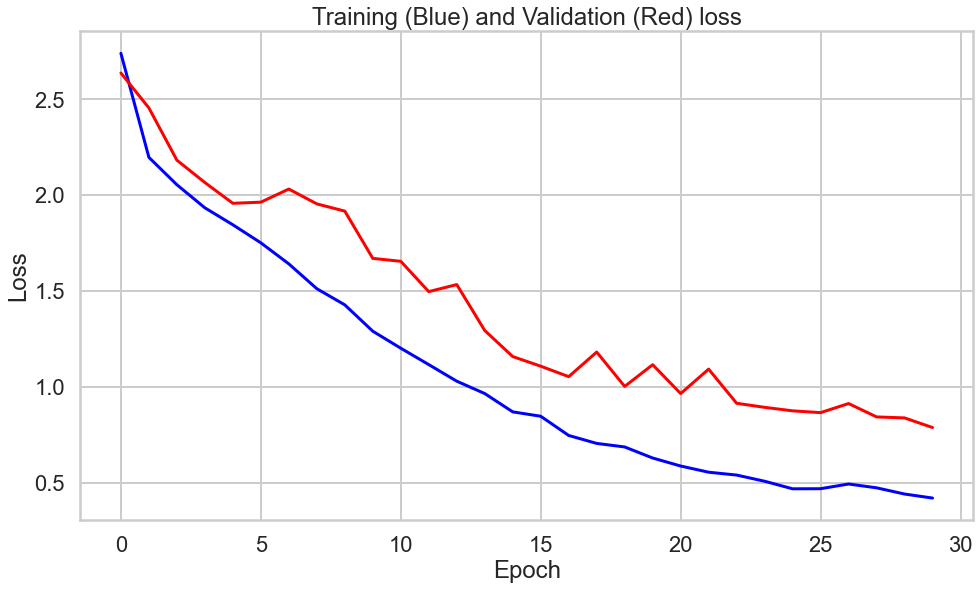

In [15]:
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set_style("whitegrid")
sns.set_context("poster")
# Plot trained loss values
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(train_loss_arr, color='blue', label='Training Loss')
ax.plot(val_loss_arr, color='red', label='Validation Loss')

ax.set_title('Training (Blue) and Validation (Red) loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
# plt.savefig('3-2:training_loss.png')
plt.show()

## Evaluation

Cosine similarity measures the similarity between the estimated and actual positions. The cosine similarity is a number between 0 and 1, where a number close to 1 indicates a high similarity.

MSE measures the average squared difference between the estimated future positions and the actual future positions. Thus, the ideal value for MSE would be 0.

To further evaluate the performance of the model, the best and the worst future position estimations of the model are plotted, along with the real future positions. To obtain the ranking of the estimates, the MSE obtained for each simulation were used. The best estimate is the one with the lowest MSE, while the worst is the one with the highest.

In [16]:
def test_performance(test_dataset):
    seq2seq.load_state_dict(torch.load('seq2seq_model.pt'))
    seq2seq.eval()
    
    test_loss = []
    test_similarity = []
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    
    dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    pred = []
    
    with torch.no_grad():
    
        for i, (sim_test, sim_cont_test) in enumerate(dataloader):
            output = seq2seq(sim_test.to(device), sim_cont_test.to(device))
            
            similarity = cos(output, sim_cont_test.to(device)).mean() 
            test_similarity.append(similarity.item())
            
            loss = seq2seq.criterion(output, sim_cont_test.to(device))
            test_loss.append(loss.item())
            
            pred.append(output)
            
            torch.cuda.empty_cache()

        print(f'TEST COSINE SIMILARITY: {np.mean(test_similarity):.4f}',end=' ')
        print(f'TEST MSE: {np.mean(test_loss):.4f}',end=' ')
        print()
        
        return test_loss, pred

TEST COSINE SIMILARITY: 0.8178 TEST MSE: 0.7970 
Best prediction:
Truth:


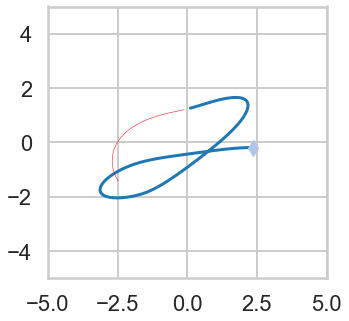

Prediction:


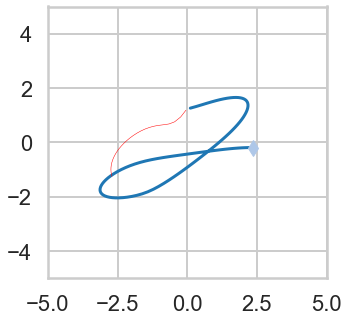


Worst prediction:
Truth:


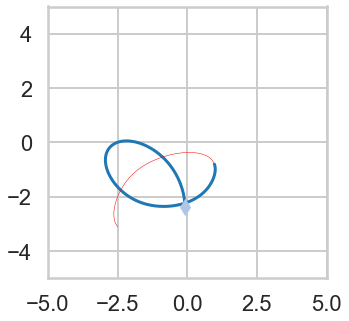

Prediction:


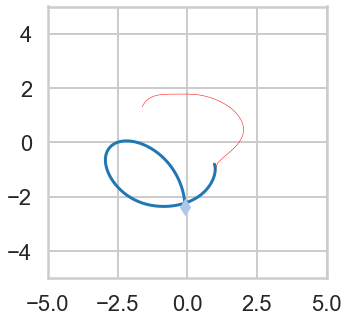

In [17]:
test_loss, predictions = test_performance(test_dataset)
ranked_simulations = sorted(range(len(test_loss)), key=lambda k: test_loss[k])

print('Best prediction:')
print('Truth:')
plot_example(simulation_test[ranked_simulations[0]], simulation_continued_test[ranked_simulations[0]])
print('Prediction:')
plot_example(simulation_test[ranked_simulations[0]], np.array(predictions[ranked_simulations[0]][0].cpu().numpy()))

print()

print('Worst prediction:')
print('Truth:')
plot_example(simulation_test[ranked_simulations[-1]], simulation_continued_test[ranked_simulations[-1]])
print('Prediction:')
plot_example(simulation_test[ranked_simulations[-1]], np.array(predictions[ranked_simulations[-1]][0].cpu().numpy()))

## Linear Baseline:

A linear baseline was implemented, which estimates the future positions for each simulation, by the following rule: $p_t = p_t + (p_t - p_{t-1})$. After all future position estimates are made for a simulation, the cosine similarity and the MSE between the estimates and the true positions are computed.

In [18]:
# Linear baseline
criterion = lambda x,y: np.square(np.subtract(x, y)).mean()
cos = lambda x,y: (x * y).sum(axis=1) / np.linalg.norm(x, axis=1) / np.linalg.norm(y, axis=1)

baseline_losses = []
baseline_similarity = []
predictions = []

for simulation in range(len(simulation_test)):
    xt = simulation_test[simulation][-1]
    xt2 = simulation_test[simulation][-2]
    pred = []
    for timestep in range(len(simulation_continued_test[simulation])):
        new_xt = xt + (xt - xt2)
        new_xt2 = xt
        
        pred.append(new_xt)
        
        xt = new_xt
        xt2 = new_xt2

    loss = criterion(pred, simulation_continued_test[simulation])
    baseline_losses.append(loss)
    similarity = cos(np.array(pred), np.array(simulation_continued_test[simulation])).mean()
    baseline_similarity.append(similarity)
    
    predictions.append(pred)
      
print(f'Baseline SIMILARITY: {np.mean(baseline_similarity):.4f}',end=' ')
print(f'Baseline MSE: {np.mean(baseline_losses):.4f}',end=' ')

Baseline SIMILARITY: 0.7543 Baseline MSE: 2.8848 

The cosine similarity of the baseline is slightly lower than the one obtained by the Seq2Seq model. However, the Seq2Seq model has a much better MSE result.

Best prediction:
Truth:


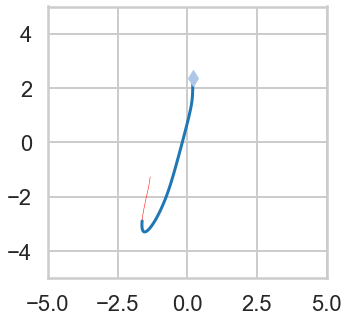

Prediction:


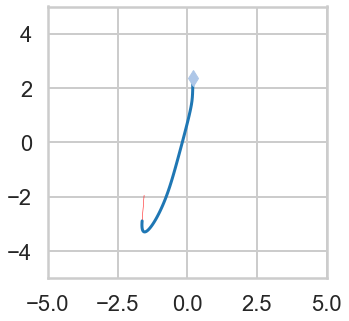


Worst prediction:
Truth:


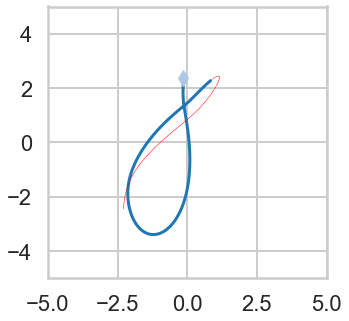

Prediction:


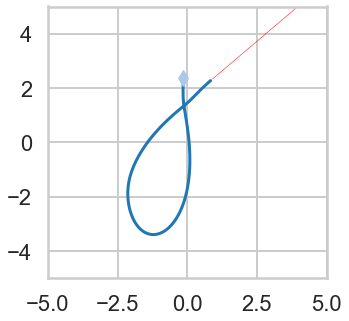

In [19]:
ranked_simulations = sorted(range(len(baseline_losses)), key=lambda k: baseline_losses[k])

print('Best prediction:')
print('Truth:')
plot_example(simulation_test[ranked_simulations[0]], simulation_continued_test[ranked_simulations[0]])
print('Prediction:')
plot_example(simulation_test[ranked_simulations[0]], np.array(predictions[ranked_simulations[0]]))

print()

print('Worst prediction:')
print('Truth:')
plot_example(simulation_test[ranked_simulations[-1]], simulation_continued_test[ranked_simulations[-1]])
print('Prediction:')
plot_example(simulation_test[ranked_simulations[-1]], np.array(predictions[ranked_simulations[-1]]))

It can be seen that although the linear baseline can estimate cases, where the real future trajectory is a straight line, it cannot capture complex trajectories.